In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, make_scorer, f1_score
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [5]:
path = "F:/for learn/Python_MachineLearning/"
df = pd.read_csv(path + "wdbc.data", header=None)
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
pipe_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=1, probability=True))])

In [63]:
pipe_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
  verbose=False))])

In [19]:
y_pred = le.inverse_transform(pipe_svc.predict(X_test))
y_true = le.inverse_transform(y_test)

In [22]:
# column方向是预测， row方向是实际
confmat = confusion_matrix(y_pred=y_pred, y_true=y_true, labels=le.classes_)

array([[67,  0],
       [ 2, 45]], dtype=int64)

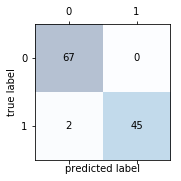

In [31]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [39]:
# 创建自定义评分函数，加载进 GridSearch中
scorer = make_scorer(score_func=f1_score, pos_label=0)

In [42]:
param_range = np.power(10.0, range(-3, 4))
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']
              },
              {'svc__C': param_range, 
               'svc__kernel': ['rbf'],
               'svc__gamma': param_range
              }]
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=10, 
                  n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'svc__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03]), 'svc__kernel': ['linear']}, {'svc__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03]), 'svc__kernel': ['rbf'], 'svc__gamma': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=mak

In [43]:
print(gs.best_params_)

{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


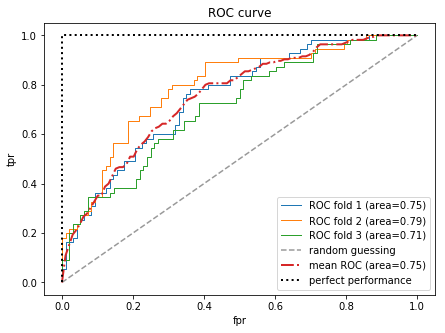

In [85]:
X_train2 = X_train[:, [4, 14]]
pipe_lr = Pipeline([("scaler", StandardScaler()), 
                    ('pca', PCA(n_components=2)),
                    ('lr', LogisticRegression(random_state=1))])
kfold = StratifiedKFold(n_splits=3, random_state=1)
cv = kfold.split(X_train2, y_train)
# 绘制 ROC曲线：各 CV及平均的
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr =[]
for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    probas = pipe_lr.predict_proba(X_train2[test])
    fpr, tpr, thresh = roc_curve(y_true=y_train[test], y_score=probas[:, 1], pos_label=1)
    # 线性插值
    mean_tpr += interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label="ROC fold %d (area=%.2f)" % (i+1, roc_auc))

plt.plot([0, 1], 
         [0, 1], 
         linestyle="--", 
         color=(0.6, 0.6, 0.6), 
         label="random guessing")
mean_tpr = mean_tpr/(i+1)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, 
         mean_tpr, 
         linestyle="-.", 
         label="mean ROC (area=%.2f)" % mean_auc, lw=2)
plt.plot([0, 0, 1], 
         [0, 1, 1], 
         lw=2, 
         linestyle=':', 
         color="black", 
         label="perfect performance")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [99]:
y_pred_proba = pipe_lr.predict_proba(X_test[:,[4, 14]])
fpr, tpr, thresh = roc_curve(y_true=y_test, y_score=y_pred_proba[:, 1], pos_label=1)
print("the AUC score of pipe_lr: %.3f" % auc(fpr, tpr))

the AUC score of pipe_lr: 0.747
